In [186]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

---
## Setting up a connection

In [187]:
con = sqlite3.connect('../data/checking-logs.sqlite')

---
## Checking up the tables we have

In [188]:
pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', con)

,name
0,pageviews
1,checker
2,deadlines
3,datamart
4,test
5,control


---
## Checking up the tables' content

In [189]:
pd.read_sql('SELECT * FROM pageviews LIMIT 3', con)

,index,uid,datetime
0,0,admin_1,2020-04-17 12:01:08.463179
1,1,admin_1,2020-04-17 12:01:23.743946
2,2,admin_3,2020-04-17 12:17:39.287778


In [190]:
pd.read_sql('SELECT * FROM checker LIMIT 3', con)

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1


In [191]:
pd.read_sql('SELECT * FROM deadlines LIMIT 3', con)

,index,labs,deadlines
0,0,laba04,1587945599
1,1,laba04s,1587945599
2,2,laba05,1588550399


In [192]:
pd.read_sql('SELECT * FROM test LIMIT 10', con)

,index,uid,labname,first_commit_ts,first_view_ts
0,0,user_17,project1,2020-04-18 07:56:45.408648,2020-04-18 10:56:55.833899
1,1,user_30,laba04,2020-04-18 13:36:53.971502,2020-04-17 22:46:26.785035
2,2,user_30,laba04s,2020-04-18 14:51:37.498399,2020-04-17 22:46:26.785035
3,3,user_14,laba04,2020-04-18 15:14:00.312338,2020-04-18 10:53:52.623447
4,4,user_14,laba04s,2020-04-18 22:30:30.247628,2020-04-18 10:53:52.623447
5,5,user_19,laba04,2020-04-20 19:05:01.297780,2020-04-21 20:30:38.034966
6,6,user_25,laba04,2020-04-20 19:16:50.673054,2020-05-09 23:54:54.260791
7,7,user_21,laba04,2020-04-21 17:48:00.487806,2020-04-22 22:40:36.824081
8,8,user_30,project1,2020-04-22 12:36:24.053518,2020-04-17 22:46:26.785035
9,9,user_21,laba04s,2020-04-22 20:09:21.857747,2020-04-22 22:40:36.824081


---
## Creating dataframe

where each ***user*** of the `test` group has the `average difference`, `number of pageviews` and `number of commits`

In [193]:
query = """
SELECT
    diffs.uid,
    diffs.avg_diff,
    views.pageviews,
    commits.commits
FROM
    (SELECT
        uid,
        AVG(CAST((julianday(t.first_commit_ts) - julianday(d.deadlines, 'unixepoch')) * 24 AS INTEGER)) avg_diff
    FROM
        test t
    LEFT JOIN
        deadlines d
    ON
        t.labname = d.labs
        WHERE t.labname != 'project1'
    GROUP BY uid
    ) diffs
    
LEFT JOIN
    
    (SELECT
        uid,
        COUNT(datetime) pageviews
    FROM
        pageviews
    WHERE
        uid LIKE 'user_%'
    GROUP BY uid
    ) views
    
ON diffs.uid = views.uid

LEFT JOIN

    (SELECT
        uid,
        COUNT(timestamp) commits
    FROM
        checker
    WHERE
        uid LIKE 'user_%'
        AND labname != 'project1'
    GROUP BY uid
    ) commits
    
ON diffs.uid = commits.uid
"""
users = pd.read_sql(query, con)
users

,uid,avg_diff,pageviews,commits
0,user_1,-64.400000,28,62
1,user_10,-74.800000,89,20
2,user_14,-159.000000,143,61
3,user_17,-61.600000,47,51
4,user_18,-5.666667,3,5
5,user_19,-98.750000,16,118
6,user_21,-95.500000,10,65
7,user_25,-92.600000,179,79
8,user_28,-86.400000,149,60
9,user_3,-105.400000,317,18


---
## Drawing a plot

- the `figsize` is `(15, 8)`, any `fontsize` and `color` palette
- the `dotsize` (`s`) should be `200`
- the `lines_width` of the diagonal graphs (`kde`) should be `3`

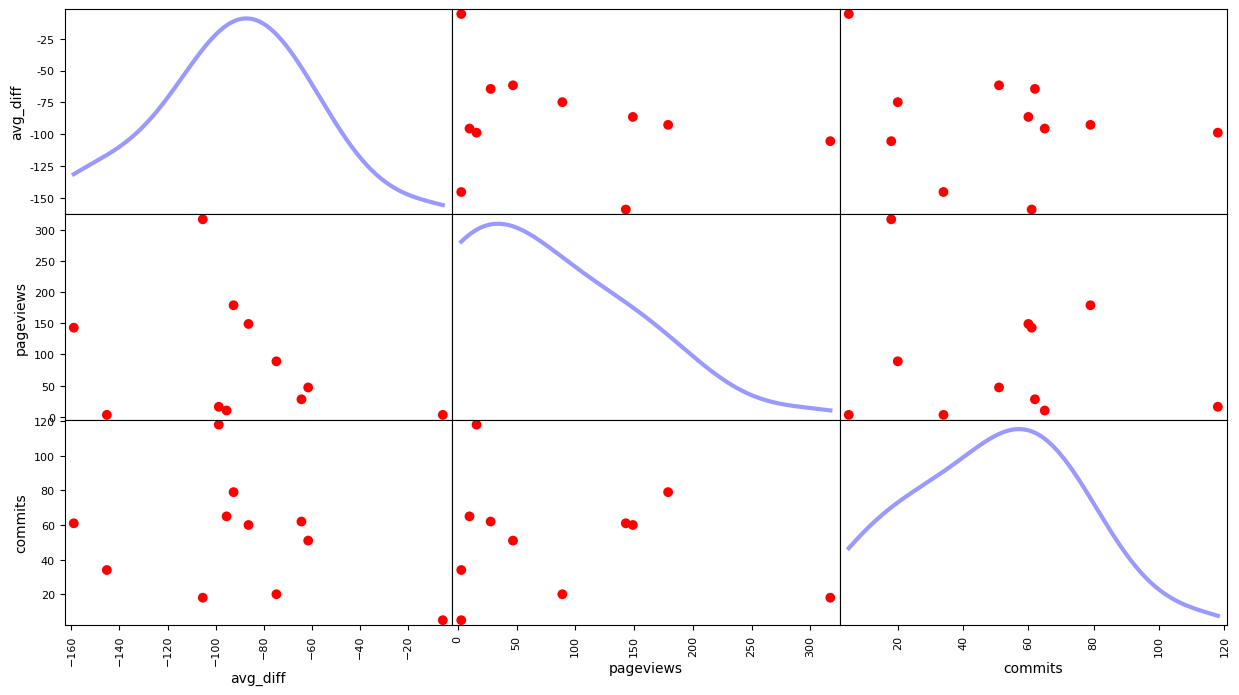

In [194]:
sx = scatter_matrix(users.loc[:, users.columns!='uid'],
                    figsize=(15, 8), s=200,
                    diagonal='kde', density_kwds={'color':'blue', 'linewidth':3, 'alpha':0.4},
                    color='red', alpha=1.)

# Changing fontsize
# for ax in sx.ravel(): 
#     ax.tick_params(axis='both', labelsize=8)
#     ax.set_xlabel(ax.get_xlabel(), fontsize = 16)
#     ax.set_ylabel(ax.get_ylabel(), fontsize = 16)

---
## Closing the connection

In [195]:
con.close()

---
## Questions

1. Can we say that if a user has a ***low number*** of `pageviews` then they likely have a ***low number*** of `commits`?
> No
1. Can we say that if a user has a ***low number*** of `pageviews` then they likely have a ***small*** `avg_diff` (average difference between the first commit and the lab deadline)?
> No
1. Can we say that there are ***many users*** with a ***low number*** of `commits` and a ***few*** with a ***high number*** of `commits`?
> Yes
1. Can we say that there are ***many users*** with a ***small*** `avg_diff` (average difference) and a ***few*** with a ***large*** `avg_diff` (average difference)?
> No